In [26]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
contaminated_df = pd.read_csv("../../data/contaminated/data_contaminated3.csv")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
#contaminated_df.head

<bound method NDFrame.head of                                           combined_text
0     cardiac silhouette mediastinum size within nor...
1     cardiomediastinal silhouette within normal lim...
2     lung clear epanded heart mediastinum normal ac...
3     increased_opacity within right_upper_lobe poss...
4     interstitial marking diffusely prominent throu...
...                                                 ...
3414  lung clear cardiomediastinal silhouette within...
3415  sternotomy suture bypass graft placed interval...
3416  calcified mediastinal focal area consolidation...
3417  Temperature of 42°C, despite being on antipyre...
3418  lung clear bilaterally focal consolidation ple...

[3419 rows x 1 columns]>

In [8]:
contaminated_sentences = contaminated_df['combined_text'].tolist()
embeddings = model.encode(contaminated_sentences)

print(embeddings[:5])


[[ 0.28227794  0.12621348 -0.05208312 ... -0.07339635  0.24025863
   0.1327806 ]
 [ 0.43039504  0.03634816 -0.04758246 ... -0.22186738 -0.22349276
   0.06129763]
 [ 0.27479756  0.28263614  0.24597012 ... -0.0940499   0.38327062
   0.55718064]
 [ 0.3451237   0.03631111  0.24890196 ... -0.16847862 -0.6559895
   0.48840496]
 [ 0.35484728  0.07293423  0.34847844 ...  0.02546211  0.13973124
   0.35689235]]


In [18]:
# Normalisation des données
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

In [20]:
# Diviser en ensembles d'entraînement et de test
X_train, X_test = train_test_split(scaled_embeddings, test_size=0.2, random_state=42)

In [34]:
#partie compression de l'entree
input_dim = embeddings.shape[1]
encoding_dim = 32
print(input_dim)

384


In [22]:
input_layer = keras.Input(shape=(input_dim,))
# Encodeur
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

# Décodeur
decoder = layers.Dense(64, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='sigmoid')(decoder)

2025-03-07 23:22:56.211808: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [23]:
# Modèle complet
autoencoder = keras.Model(input_layer, decoder)

# Modèle encodeur (pour extraire les features compressées)
encoder_model = keras.Model(input_layer, encoder)

# Compiler le modèle
autoencoder.compile(optimizer='adam', loss='mse')

In [24]:
# Entraîner l'auto-encodeur
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1336 - val_loss: 0.8973
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9012 - val_loss: 0.8254
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8337 - val_loss: 0.7894
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8029 - val_loss: 0.7683
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7803 - val_loss: 0.7541
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7709 - val_loss: 0.7437
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7531 - val_loss: 0.7355
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7411 - val_loss: 0.7297
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7285 - val_loss: 0.7240
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7396 - val_loss: 0.7195
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7301 - val_loss: 0.7160
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7175 - val_lo

In [27]:
# Reconstruire les inputs
reconstructed = autoencoder.predict(scaled_embeddings)

# Calculer l'erreur de reconstruction
mse = np.mean(np.power(scaled_embeddings - reconstructed, 2), axis=1)

# Ajouter les scores d'anomalie au DataFrame
contaminated_df['reconstruction_error'] = mse

# Extraire les embeddings réduits
reduced_embeddings = encoder_model.predict(scaled_embeddings)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step


In [28]:
reduced_embeddings_df = pd.DataFrame(
    reduced_embeddings, 
    columns=[f'reduced_dim_{i}' for i in range(encoding_dim)]
)

In [30]:
# Sauvegarder les résultats
final_df = pd.concat([contaminated_df, reduced_embeddings_df], axis=1)
final_df.to_csv("../../data/contaminated/autoencoder_results.csv", index=False)

threshold = np.percentile(mse, 95)  # Les 5% supérieurs sont considérés comme anomalies
contaminated_df['is_anomaly'] = mse > threshold

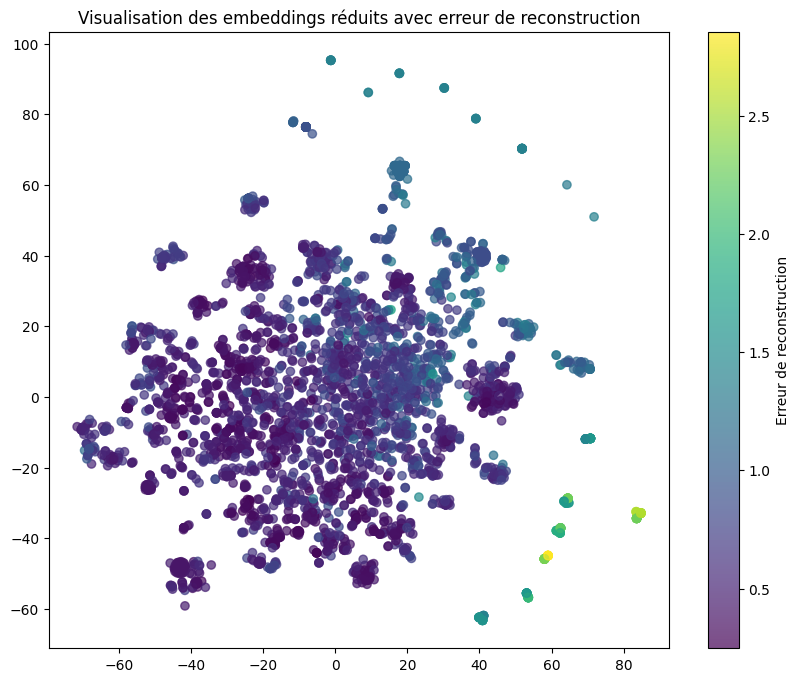

In [31]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduire à 2D pour la visualisation si encoding_dim > 2
if encoding_dim > 2:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_2d = tsne.fit_transform(reduced_embeddings)
else:
    reduced_2d = reduced_embeddings

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], 
                     c=mse, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Erreur de reconstruction')
plt.title('Visualisation des embeddings réduits avec erreur de reconstruction')
plt.savefig('embeddings_visualization.png')
plt.show()